In [ ]:
!pip install keras-tuner
!pip install --upgrade tensorflow

In [38]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np

In [42]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [40]:
(x_train, y_train),(x_test, y_test) =tf.keras.datasets.fashion_mnist.load_data()

In [20]:
x_train.shape

(60000, 28, 28)

In [21]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Text(0.5, 1.0, '9')

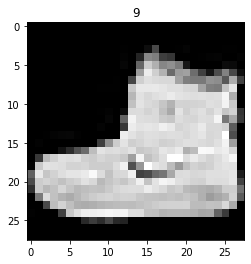

In [23]:
plt.imshow(x_train[0], cmap="gray")
plt.title(y_train[0])

#

In [24]:
def create_model(hp):
    num_hidden_layers =1
    num_units=8
    dropout_rate=0.1
    learning_rate=0.01
    if hp:
        num_hidden_layers = hp.Choice('num_hidden_layers', values=(1,2,3))
        num_units = hp.Choice("num_units",values=(8,16,32))
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        learning_rate = hp.Float('learning_rate',min_value=0.0001, max_value=0.01)
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    model.add(tf.keras.layers.Lambda(lambda x:x/255.)) # une couche lambda pour normaliser les pixels
    for _ in range(0, num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=["accuracy"])
    return model

Maintenant que le model est construit on peu afficher son architecture en appliquant la méthode **summary**  


In [25]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 6280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Ceci est notre model avec les paramètres par défaut
Créons maintenantant une classe quie hérite d'une classe du package **kerastuner**

In [27]:
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs["batch_size"] = trial.hyperparameters.Int("batch_size", 32,128, step=32)
        super(CustomTuner, self).run_trial(trial,*args,**kwargs)

In [28]:
tuner = CustomTuner(
    create_model,
    objective= "val_accuracy",
    max_trials=20,
    directory='logs',
    project_name="fashion_mnist",
    overwrite=True
)

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [30]:
tuner.search(
   x_train, y_train ,
   validation_data=(x_test, y_test),
   epochs=5
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_hidden_layers |3                 |?                 
num_units         |16                |?                 
dropout_rate      |0.16266           |?                 
learning_rate     |0.0079301         |?                 



AttributeError: module 'tensorflow._api.v2.distribute' has no attribute 'TPUStrategy'

In [ ]:
model= tuner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

In [ ]:
_ = model.fit(
    x_train,y_train,
    validation_data=(x_test, y_test),
    epochs=20)